# Plotting jets as images

In [1]:
import time

from coffea import hist
from coffea.analysis_objects import JaggedCandidateArray
import coffea.processor as processor
from awkward import JaggedArray
import numpy as np
import glob as glob
import itertools
import json
import uproot_methods
import copy
from coord_transform import *

In [2]:
def transform_to_softdrop_axes(jetparticles,Jets):
    
    
    subjet0leading = (Jets.subjet0_pt > Jets.subjet1_pt)
    centroid1_pt = np.where( subjet0leading, Jets.subjet0_pt, Jets.subjet1_pt  )
    centroid1_eta = np.where( subjet0leading, Jets.subjet0_eta, Jets.subjet1_eta  )
    centroid1_phi = np.where( subjet0leading, Jets.subjet0_phi, Jets.subjet1_phi  )
    centroid1_m = np.where( subjet0leading, Jets.subjet0_m, Jets.subjet1_m  )
    centroid2_pt = np.where( subjet0leading, Jets.subjet1_pt, Jets.subjet0_pt,   )
    centroid2_eta = np.where( subjet0leading, Jets.subjet1_eta, Jets.subjet0_eta  )
    centroid2_phi = np.where( subjet0leading, Jets.subjet1_phi, Jets.subjet0_phi  )
    centroid2_m = np.where( subjet0leading, Jets.subjet1_m, Jets.subjet0_m  )
    centroid1 = uproot_methods.TLorentzVectorArray.from_ptetaphim( centroid1_pt, centroid1_eta, centroid1_phi, centroid1_m )
    centroid2 = uproot_methods.TLorentzVectorArray.from_ptetaphim( centroid2_pt, centroid2_eta, centroid2_phi, centroid2_m )
    
    # Rotate coordinate system so "centroid1" is along the z axis
    rot1_axis, rot1_angle = coord_rotation( centroid1.p3, uproot_methods.TVector3(0,0,1) )
    jetparticles = jetparticles.rotate_axis( rot1_axis, rot1_angle)
    centroid2 = centroid2.rotate_axis( rot1_axis, rot1_angle )
    # Now rotate again so that "centroid2" is along x axis
    rot2_axis, rot2_angle = coord_rotation( centroid2,p3, uproot_method.TVector3(1,0,0) )
    jetparticles = jetparticles.rotate_axis( rot2_axis, rot2_angle )

    return jetparticles
    

In [10]:
# Look at ProcessorABC to see the expected methods and what they are supposed to do
class JetImageProcessor(processor.ProcessorABC):
    def __init__(self):
        dataset_axis = hist.Cat("dataset", "Primary dataset")
        pdgid_axis = hist.Bin("pdgid", r"PDG ID", 10000, -5000, 5000)
        eta_axis = hist.Bin("eta", r"$\eta$", 32, -5, 5)
        phi_axis = hist.Bin("phi", r"$\phi$", 32, -np.pi, np.pi)
        pt_axis = hist.Bin("pt", r"$p_{T}$ [GeV]", 
                           np.array([0,5,10,15,20,25,30,35,40,45,50,60,70,80,90,
                                     100,120,140,160,180,
                                     200,250,300,350,400,450,500,
                                     600,700,800,900,1000,
                                     1500,2000,3000,4000,5000]))
        m_axis = hist.Bin("m", r"$p_{T}$ [GeV]", 200, 0, 500)
        dr_axis = hist.Bin("dr", r"$\Delta r$", 80, 0, 0.8)
        
        self._accumulator = processor.dict_accumulator({
            'pt':hist.Hist("Counts", dataset_axis, pt_axis),
            'eta':hist.Hist("Counts", dataset_axis, eta_axis),
            'image':hist.Hist("Counts", dataset_axis, eta_axis, phi_axis),
            'dr':hist.Hist("Counts", dataset_axis, dr_axis),
            'pdgid':hist.Hist("Counts", dataset_axis, pdgid_axis),
            'cutflow': processor.defaultdict_accumulator(int)
        })
    
    @property
    def accumulator(self):
        return self._accumulator
    
    def process(self, df):
        output = self.accumulator.identity()

        #print("1")
        dataset = df['dataset']
        Jets = JaggedCandidateArray.candidatesfromcounts(
            df['nJet'],
            pt=df['jet_pt'],
            eta=df['jet_eta'],
            phi=df['jet_phi'],
            mass=df['jet_m'],
            msd=df['jet_msd'],
            subjet0_pt=df['jet_subjet0_pt'],
            subjet0_eta=df['jet_subjet0_eta'],
            subjet0_phi=df['jet_subjet0_phi'],
            subjet0_m=df['jet_subjet0_m'],
            subjet1_pt=df['jet_subjet1_pt'],
            subjet1_eta=df['jet_subjet1_eta'],
            subjet1_phi=df['jet_subjet1_phi'],
            subjet1_m=df['jet_subjet1_m'],
            ic=df['jet_ic']
            )        
        particles = JaggedCandidateArray.candidatesfromcounts(
            df['nGen'],
            pt=df['gen_pt'],
            eta=df['gen_eta'],
            phi=df['gen_phi'],
            mass=df['gen_m'],
            pdgid=df['gen_id'],
            status=df['gen_status']
            )
        
        particles = particles[particles.status == 84]
                        
        dr = Jets[:,0].p4.delta_r(particles.p4)
        jetparticles = particles[dr < 0.8]
        
        jetparticles = transform_to_softdrop_axes(jetparticles, Jets[:,0])
        
        output['pt'].fill(dataset=dataset,
                            pt=Jets.pt.flatten())
        output['eta'].fill(dataset=dataset, 
                                 eta=Jets.eta.flatten())
        output['image'].fill(dataset=dataset, 
                            eta=jetparticles.eta.flatten(),
                            phi=jetparticles.phi.flatten())
        output['dr'].fill(dataset=dataset,dr=dr.flatten())
        output['pdgid'].fill(dataset=dataset, pdgid=jetparticles.pdgid.flatten())
        return output

    def postprocess(self, accumulator):
        return accumulator

In [11]:


fileset={
    'Zprime1TeV':['/mnt/data/ml/gravkk_zz_1TeV_addsubstructure.root'],
    #'Zprime2TeV':['/mnt/data/ml/gravkk_zz_2TeV_addsubstructure.root'],
    #'Zprime3TeV':['/mnt/data/ml/gravkk_zz_3TeV_addsubstructure.root'],
    #'QCD':'/mnt/data/ml/qcd_flat15to7000_addsubstructure.root'
}
tstart = time.time() 
output = processor.run_uproot_job(fileset,
                                  treename='T',
                                  processor_instance=JetImageProcessor(),
                                  executor=processor.futures_executor,
                                  executor_args={'workers':1, 'flatten': True},
                                  chunksize=50000,
                                  
                                 )


elapsed = time.time() - tstart
print(output)

Processing:   0%|          | 0/2 [00:00<?, ?items/s]

Called transform 1
subjet0leading shape:  (50000,)
Called transform 2


/usr/local/jupyter/lib/python3.6/site-packages/awkward/array/table.py:692: RuntimeWarning: invalid value encountered in arccos
  newcolumns[n] = getattr(ufunc, method)(*x, **kwargs)
Processing:   0%|          | 0/2 [00:15<?, ?items/s]


Called transform 1
subjet0leading shape:  (49888,)
Called transform 2


TypeError: cannot call cross on ObjectArray

In [8]:
import matplotlib.pyplot as plt

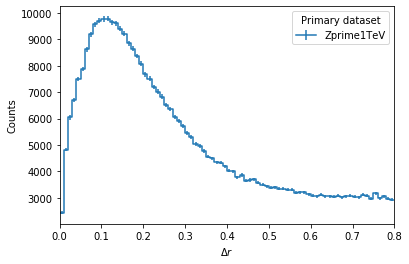

In [9]:
fig, ax = hist.plotgrid(output['dr'], overlay="dataset", stack=False
                                 )
for iax in ax.flatten():
    iax.autoscale(axis='y')
fig.show()